In [1]:
import copy

import pandas as pd

import tarfile


import os
import urllib

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F


from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [2]:
cd '/content/drive/MyDrive/Colab Notebooks/Работа/'

/content/drive/MyDrive/Colab Notebooks/Работа


In [3]:
from DataLoader import *
from Train_process import  *
from Dropaut_Resnet import *
from Contextual_Resnet import *

#Загрузим данные и разместим на диске:

In [42]:
! wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz

--2021-04-18 00:16:24--  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.132.24
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.132.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328387740 (313M) [application/x-tar]
Saving to: ‘imagewoof2-320.tgz.2’

imagewoof2-320.tgz.  30%[=====>              ]  96.11M  30.1MB/s    eta 7s     ^C


In [43]:
tar = tarfile.open("imagewoof2-320.tgz")
tar.extractall()
tar.close()

KeyboardInterrupt: ignored

# Загрузим файлы

In [4]:
DEVICE = torch.device("cuda")

In [5]:
TEST_DIR = Path('imagewoof2-320/val')
TRAIN_DIR = Path('imagewoof2-320/train')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.JPEG')))
test_files = sorted(list(TEST_DIR.rglob('*.JPEG')))

In [6]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [7]:
val_dataset = MyDataset(val_files, mode='val')

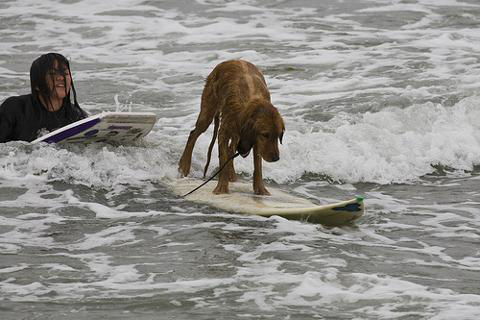

In [8]:
val_dataset.load_sample(val_files[0])

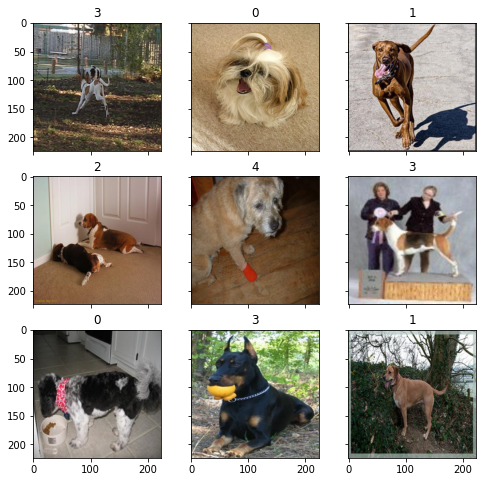

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    imshow(im_val.data.cpu(), \
          title=label,plt_ax=fig_x)

# ResNet без Dropout:

In [49]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)


for param in model.parameters():
    param.requires_grad = False


num_features = 512

n_classes = len(np.unique(train_val_labels))
model.fc = nn.Linear(num_features, n_classes)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [50]:
# DEVICE = torch.device("cuda")
DEVICE = torch.device("cpu")
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Натренируем модель:

In [12]:
if val_dataset is None:
    val_dataset = MyDataset(val_files, mode='val')
    
train_dataset = MyDataset(train_files, mode='train')

In [13]:
history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=64, DEVICE=DEVICE)

epoch:   0%|          | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [60]:
def plot_res(loss, val_loss, acc):
  
    fig1, ax1 = plt.subplots(figsize=(15, 9))
    ax1.plot(loss, label="train_loss")
    ax1.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    ax1.xlabel("epochs")
    ax1.ylabel("loss")
    plt.show()


    fig2, ax2 = plt.subplots(figsize=(15, 9))
    ax2.plot(loss, label="train_loss")
    ax2.plot(acc, label="accuracy")
    plt.legend(loc='best')
    ax2.xlabel("epochs")
    ax2.ylabel("accuracy")
    plt.show()

    return 0




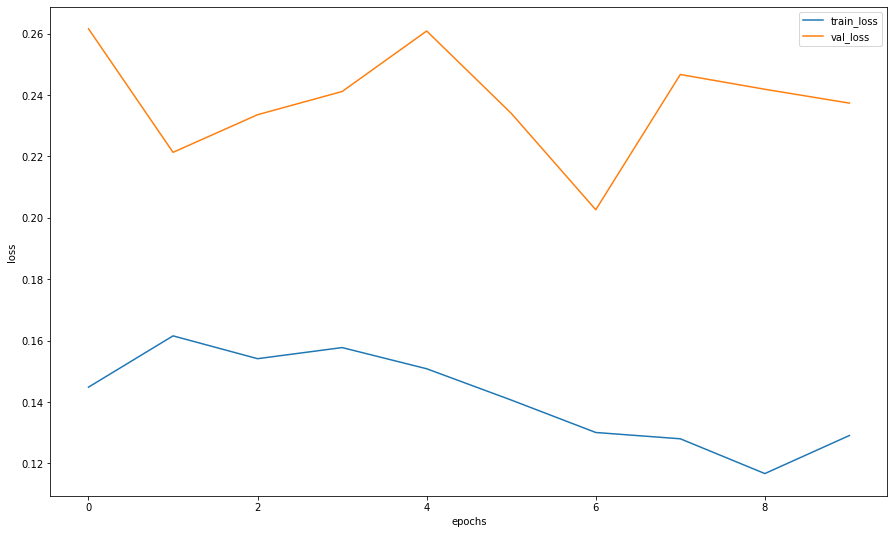

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

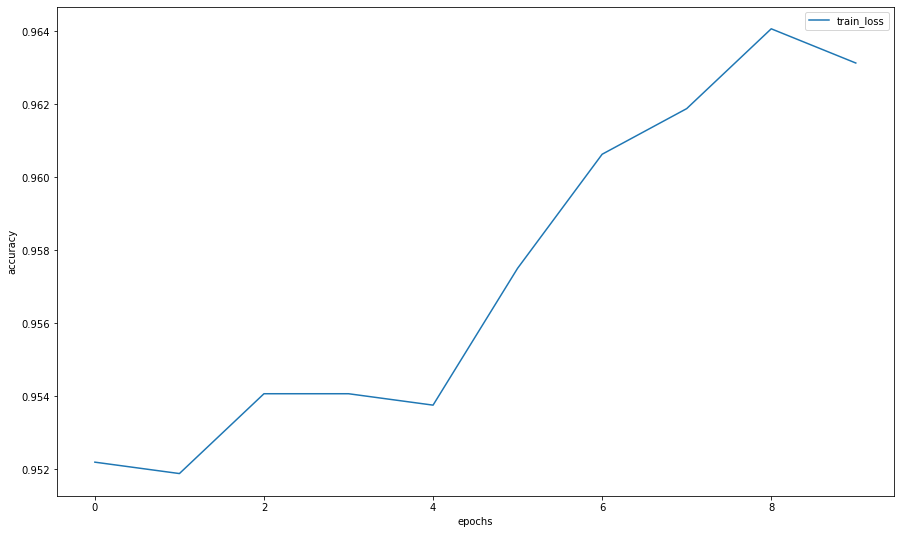

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

# Предсказания, метрики:

In [51]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [61]:
def calc_metrics(model, DEVICE = 'cpu', el_num = 400, cert_lev = 0.9):

    idxs = list(map(int, np.random.uniform(0,2000, el_num)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs, DEVICE = DEVICE)
    y_pred = np.argmax(probs_ims,-1)

    actual_labels = [val_dataset[id][1] for id in idxs]

    top1_acc = accuracy_score(actual_labels, y_pred, )
    f1_score_multi = f1_score(actual_labels, y_pred, average = None)

    top1_prob, top1_catid = torch.topk(torch.tensor(probs_ims), 1)


    acc_list = []
    cert_list = []

    for y_real, y_pred, prob_pred in zip(actual_labels, top1_catid, top1_prob):
        if y_pred == y_real:
            acc_list.append(1)
        else:
            acc_list.append(0)

        if prob_pred > cert_lev:
            cert_list.append(1)
        else:
            cert_list.append(0)

    acc = np.array(acc_list)
    cert = np.array(cert_list)

    PAvPU = (sum(acc*cert) + sum((1-acc)*(1-cert)))/(sum(acc*cert) + sum((1-acc)*(1-cert)) + sum((1-acc)*cert) + sum(acc*(1-cert)))

    print('Top1 acc: ' + str(top1_acc))
    print('Multi-lable F1_score: ' + str(f1_score_multi))
    print('PAvPU:' + str(PAvPU))

    return 'done'






In [62]:
calc_metrics(model, DEVICE = 'cpu', el_num = 400,cert_lev = 0.9)

Top1 acc: 0.1575
Multi-lable F1_score: [0.43298969 0.         0.         0.17266187 0.         0.
 0.         0.08163265 0.21374046]
PAvPU:0.8425


'done'

In [58]:
import copy

def save_model(model, name = 'ResNet_no_dropout' ):
    model_weights = copy.deepcopy(model.state_dict())
    torch.save(model_weights, 'Models/'+name+'_weights.pth') 
    torch.save(model, 'Models/'+name+'.pth') 
    return 'saved'

def load_model(name = 'ResNet_no_dropout' ):
    model = torch.load('Models/'+name+'.pth') 
    return model

In [59]:
save_model(model, name = 'ResNet_base')

'saved'

# Метрики:

# Dropaut model:

In [63]:
model = ResNet_DropOut()

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

model.eval()

ResNet_DropOut(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer11): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop11): Dropout2d(p=0.5, inplace=False)
  (layer12): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReL

In [32]:
history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=64, DEVICE=DEVICE)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])


epoch:   0%|          | 0/10 [01:25<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plot_res(loss, val_loss, acc)

In [ ]:
calc_metrics(model, DEVICE = 'cpu', el_num = 400,cert_lev = 0.9)

In [ ]:
save_model(model, name = 'ResNet_dropout')

# Contextual dropaut


In [33]:
torch.pi = torch.acos(torch.zeros(1)).item() * 2

In [38]:
model =  ResNet_Contextual_DropOut()
model

ResNet_Contextual_DropOut(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer11): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop11): Context_Dropout(
    (enc_lay): Encoderblock(
      (avg1): AvgPool2d(kernel_size=(56, 56), stride=(56, 56), padding=0)
      (lin1): Linear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
      (lin2): Linear(in_features=64, 

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=64, DEVICE=DEVICE)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plot_res(loss, val_loss, acc)

In [ ]:
calc_metrics(model, DEVICE = 'cpu', el_num = 400,cert_lev = 0.9)

In [ ]:
save_model(model, name = 'ResNet_dropout')